In [1]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import geopandas as gpd


def Load_graph_from_coord(north, south, east, west):
    return ox.graph_from_bbox(north, south, east, west, network_type="drive", simplify=False)
def Load_graph_from_saved(filename):
    return ox.load_graphml(filename)
def Create_road_network(G):
    # create network from that bounding box
    fig, ax = ox.plot_graph(G, node_size = 15, node_color="#1e527e", bgcolor = "white", edge_color="black",edge_linewidth = 2)
    G2 = nx.convert_node_labels_to_integers(G,0)
    G2 = ox.project_graph(G2)

    ID = 1
    l = list(G2.edges)
    for zi in l:
        x,y,z = zi
        G2[x][y][0]["osmid"] = ID 
        G2[x][y][0]["nodes"] = str(x)+"|" + str(y) 
        ID+=1
    return G2
def Create_roads(G2):
    roads  = []

    for edge in G2.edges:
        n1,n2,d = edge

        start = G2.nodes[n1]['x'],-G2.nodes[n1]['y'] 
        end = G2.nodes[n2]['x'],-G2.nodes[n2]['y'] 
        road_params = G2[n1][n2][0]
        
        road = (start,end,road_params)
        roads.append(road)
    return roads




def Load_buildings_from_coord(north, south, east, west):
    return ox.geometries_from_bbox(north, south, east, west, {"building": True})
def Load_buildings_from_saved(filename):
    return gpd.read_file(filename)



def Polygon_refactor(polygon):
    polygon1 = np.array([polygon[0], -np.array(polygon[1])]).T
    return polygon1
def Create_buidings(gdf):
    buildings = []

    gdf_project_poly = ox.project_gdf(gdf)["geometry"]

    for poly in gdf_project_poly[:-1]:
        if (poly.geom_type == 'MultiPolygon'): 
            for ea in poly.geoms:
                buildings.append(Polygon_refactor(ea.exterior.coords.xy))
            
        elif (poly.geom_type == 'Polygon'):
            buildings.append(Polygon_refactor(poly.exterior.coords.xy))
            
    
    
    return  buildings




In [2]:
buildings_path = "data/mybuildings.gpkg"
network_path = "data/mynetwork.graphml"

def SAVE_DATA(north, south, east, west):

    nsew = north, south, east, west
    ox.save_graphml(Load_graph_from_coord(*nsew), filepath=network_path)

    gdf = Load_buildings_from_coord(*nsew).apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
    gdf.to_file(buildings_path, driver="GPKG")

In [3]:
# turn response caching off
ox.settings.use_cache = False

# turn it back on and turn on/off logging to your console
ox.settings.use_cache = True
ox.settings.log_console = False

# define a bounding box in Krsk


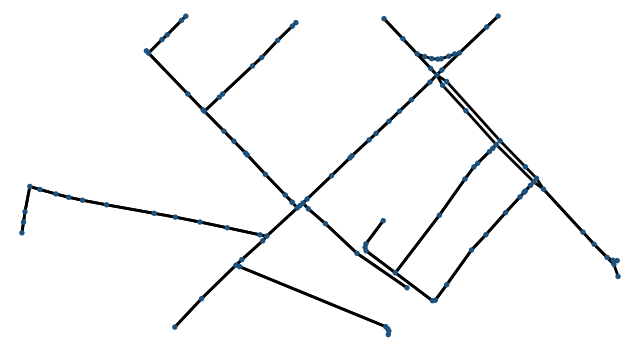

In [4]:


# define a bounding box in Krsk
#north, south, east, west = 56.0438, 56.0321, 92.8749, 92.8594
#north, south, east, west = 56.0476, 56.0171, 92.8346, 92.9000
north, south, east, west =  56.0198, 56.0132, 92.7798, 92.8006

#SAVE_DATA(north, south, east, west)

# buildings = Create_buidings(Load_buildings_from_coord(north, south, east, west))

# # create graph from .osm extract file
# G  = Create_road_network(Load_graph_from_coord(north, south, east, west))
# roads = Create_roads(G)


#SAVE_DATA(north, south, east, west)


buildings = Create_buidings(Load_buildings_from_saved(buildings_path))
G  = Create_road_network(Load_graph_from_saved(network_path))

roads = Create_roads(G)


In [5]:
import threading as thr
def Create_path(G, orig, dest, k = 2, lot_of_paths = []):
    try:
        routes = ox.k_shortest_paths(G, orig, dest, k = k, weight="length")
    except Exception as e:
        return lot_of_paths
    #fig, ax = ox.plot_graph_routes(G, list(routes), route_colors="y", route_linewidth=2, node_size=0)
    else:
        
        L = list(routes)
        for l in L:
            path = []
            for n1,n2 in zip(l[0:], l[1:]):
                path.append(G[n1][n2][0]["osmid"])
            with pool_sema: 
                if len(path): lot_of_paths.append(path)
            


lot_of_paths = []
pool_sema = thr.BoundedSemaphore(value=2)

#origs = [76, 21,  46, 106, 93]
origs = [84,85,66, 21,  46, 96, 93]
origs = [66, 21,  46, 96, 93]
dest = list(G.nodes)
dest = origs
for orig in origs:
    threads = []

    for _ in range(3):
        destp = np.random.choice(dest)
        k = 1

        t = thr.Thread(target=Create_path, args=(G,orig,destp,k,lot_of_paths, ))
        threads.append(t)
        t.start()


In [6]:
PATH = {}
origs = [66, 21,  46, 96, 93, 76]
dest = list(G.nodes)
for orig in origs:
    threads = []
    lot_of_paths = []
    for _ in range(8):
        destp = np.random.choice(dest)
        k = 4

        t = thr.Thread(target=Create_path, args=(G,orig,destp,k,lot_of_paths, ))
        threads.append(t)
        t.start()
    PATH[orig] = lot_of_paths

Exception in thread Thread-18 (Create_path):
Traceback (most recent call last):
  File "c:\python\lib\threading.py", line 1016, in _bootstrap_inner
Exception in thread Thread-20 (Create_path):
Traceback (most recent call last):
  File "c:\python\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "c:\python\lib\threading.py", line 953, in run
    self.run()
  File "c:\python\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\TimofeyT\AppData\Local\Temp\ipykernel_9492\150924766.py", line 10, in Create_path
    self._target(*self._args, **self._kwargs)
  File "C:\Users\TimofeyT\AppData\Local\Temp\ipykernel_9492\150924766.py", line 10, in Create_path
  File "c:\python\lib\site-packages\osmnx\distance.py", line 472, in k_shortest_paths
    for path in itertools.islice(paths_gen, 0, k):
  File "c:\python\lib\site-packages\networkx\algorithms\simple_paths.py", line 544, in shortest_simple_paths
  File "c:\python\lib\site-pac

In [7]:
from trafficsimulation import*


def CreateSim(iswindow = False, model_type = None, Controller = []):
    s = Simulation()

    s.create_roads(roads)   
    s.create_buildings(buildings)   


    for file in [
    "data/year_data_av_30_4.xlsx",
    "data/year_data_av_30_5.xlsx",
    "data/year_data_av_30_3.xlsx"
    ]:
        s.create_gen_from_usdc_data_collector(
            file,
            {
            'vehicles':[
                [1, {'path': path}]
                for path in PATH[46]
            ]}
        )

    for file in [
    "data/year_data_av_31_6.xlsx",
    "data/year_data_av_31_7.xlsx"
    ]:
        s.create_gen_from_usdc_data_collector(
            file,
            {
            'vehicles':[
                [1, {'path': path}]
                for path in PATH[66]
            ]}
        )

    for file in [
    "data/year_data_av_61_4.xlsx", "data/year_data_av_61_5.xlsx", "data/year_data_av_61_6.xlsx",
    ]:
        s.create_gen_from_usdc_data_collector(
            file,
            {
            'vehicles':[
                [1, {'path': path}]
                for path in PATH[76]
            ]}
        )


    

    for file in [
    "data/year_data_av_62_1.xlsx","data/year_data_av_62_2.xlsx","data/year_data_av_62_3.xlsx",
    ]:
        s.create_gen_from_usdc_data_collector(
            file,
            {
            'vehicles':[
                [1, {'path': path}]
                for path in PATH[96]
            ]}
        )


    for file in [
    "data/year_data_av_63_8.xlsx","data/year_data_av_63_7.xlsx",
    ]:
        s.create_gen_from_usdc_data_collector(
            file,
            {
            'vehicles':[
                [1, {'path': path}]
                for path in PATH[21]
            ]}
        )
        
    # origs = [66, 21,  46,66,96, 93]
    # for path in (PATH[orig] for orig in origs):
    #     s.create_gen(
    #     {
    #     'vehicle_rate': 400,
    #     'vehicles':[
    #         [1000, {'path': road}]
    #         for road in path
    #     ]}
    #     )





    tl1 = s.create_signal(
        [{208:[0,1]},{41:[0,1,2], 18:[1,2]}, {18:[0]}],
            config = { "cycle":[(True, False, True),(False, True, True),(False, True, False)], "cycle_length": [24,24,24]}
        )

    tl2 = s.create_signal(
            [{176:[0,1,2],122:[0,1,2]},{220:[0,1,2,3,4,5],88:[0,1]}],
            config = {"cycle":[ (True, False),(False, True)], "cycle_length": [60,60]}
        )
        
    # tl3 = s.create_signal(
    #         [{25:[0]},{29:[0]}],
    #         config = {"cycle":[ (True, False),(False, True)]}
    #     )
    #tl2.SwitchNphases(1)
    #MARLINController.append(s.create_control([tl3,]))
    #MARLINController.append(s.create_control([tl2,]))
    # MARLINController.append(s.create_control([tl1,tl2,]))
    #MARLINController.append(s.create_control([tl3]))

    if model_type == "FIXED":
        Controller.append(s.create_control([tl1,],"Fixed"))
        Controller.append(s.create_control([tl2,],"Fixed"))
    elif model_type == "MARL":
        Controller.append(s.create_control([tl1,],"MARLINController"))
        Controller.append(s.create_control([tl2,],"MARLINController"))
    elif model_type == "MARLIN":
        Controller.append(s.create_control([tl1,tl2],"MARLINController"))
    elif model_type == "FUZZY":
        Controller.append(s.create_control([tl1,tl2],"FLController"))
        
    if iswindow :
        offsetx,offsety = roads[0][0]

        # Start simulation
        win = Window(s, config =  {
            "width": 1920,
            "height": 1080,
            "bg_color": (255,255,255),
            "road_color" : (0,0,0),
            "car_color" : (210,210,210),
            "build_color":(30, 82, 126),
            "time_stop": 24*3600
        })
        win.offset = (-offsetx,-offsety)

        win.zoom = 1
        win.run(steps_per_update=2)
    return s

pygame 2.2.0 (SDL 2.0.22, Python 3.10.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [8]:
import threading as thr
from time import sleep

def Run_Experiment(sim, duration, MCOUNT, TOTAL_TIME, MAX_TIME):
    s = deepcopy(sim)
    s.run(duration)

    MCOUNT.append(s.MCOUNT)
    TOTAL_TIME.append(s.TOTAL_TIME)
    MAX_TIME.append(s.MAX_TIME)

for modelname in [ 
    "FIXED",
    # "FUZZY", 
    # "MARL", 
    "MARLIN"]:

    model = CreateSim(False, modelname)
    #model.t = 18*3600

    thread_num = 16
    EXP_NUM = 1
    model.t = 0 # В 17:00
    dur = 24*3600 

    MCOUNT      = []
    TOTAL_TIME  = []
    MAX_TIME    = []




    threads = []
    for x in range(EXP_NUM//thread_num):
        for y in range(thread_num):
            t = thr.Thread(target=Run_Experiment, args=(model, dur, MCOUNT, TOTAL_TIME, MAX_TIME,  ))
            threads.append(t)
            t.start()
    for y in range(EXP_NUM%thread_num):
        t = thr.Thread(target=Run_Experiment, args=(model, dur, MCOUNT, TOTAL_TIME, MAX_TIME,  ))
        threads.append(t)
        t.start()

    while len(TOTAL_TIME) < EXP_NUM: sleep(1)
    
    print(
f"""
{modelname}
{sum(MCOUNT)    / EXP_NUM }
{sum(TOTAL_TIME)/ EXP_NUM}
{sum(MAX_TIME)  / EXP_NUM}
{sum(TOTAL_TIME) / sum(MCOUNT) }
"""
    )   



FIXED
3481.0
52449.400000047244
68.99999999993724
15.067336972148016


MARLIN
3470.0
32747.60000002594
29.199999999973443
9.437348703177504



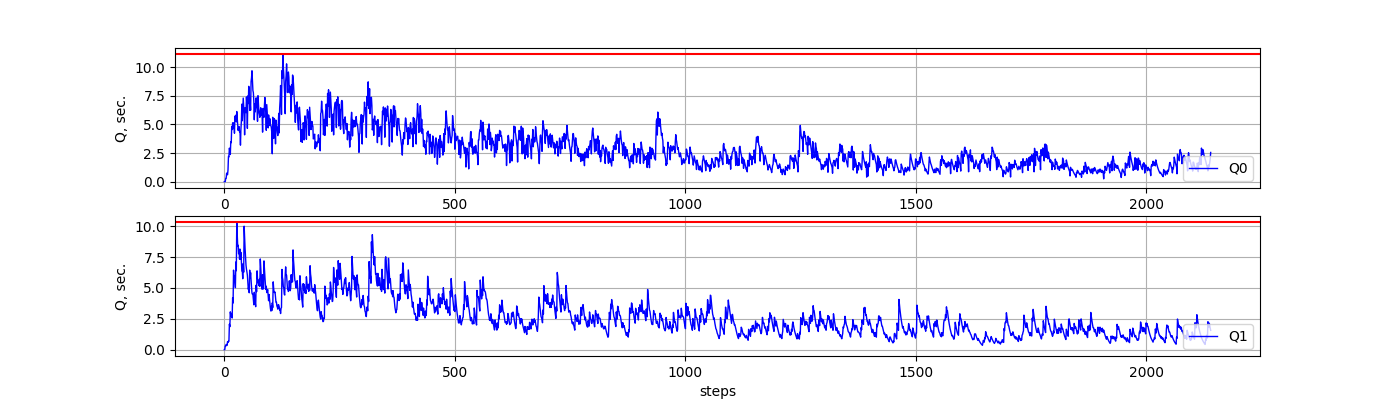

In [13]:
%matplotlib widget
MARLINController = []
s1 = CreateSim(False, "MARL", MARLINController)
dur = 24 * 3600
s1.t = 0
s1.run(dur)
s = s1

N = len(MARLINController)
fig = plt.figure(figsize=(14,2*N))
fig. tight_layout ()
for i in range(N):
    color = cm.brg(np.linspace(0, 1, len(MARLINController[i].TL)))

    ax = fig.add_subplot(N,1,i+1)
    
    ax.grid(True)
    ax.set_xlabel("steps")
    ax.set_ylabel("Q, sec.")
    for tli in range(len(MARLINController[i].TL)):
        if not(len(MARLINController[i].NB[tli])):
            data = MARLINController[i].data[tli]
            M = len(data)
            max = np.max(data)
            ax.plot(np.linspace(0,M,M),data, color = color[tli],linewidth = 1,label = f"Q{tli+i}")
            ax.axhline(max,color = "red")

        for tlij in range(len(MARLINController[i].NB[tli])-tli):
            data = MARLINController[i].data[tli][tlij]
            M = len(data)
            max = np.max(data)
            ax.plot(np.linspace(0,M,M),data, color = color[tli],linewidth = 1,label = "Q{0},{1}".format(tli+i, MARLINController[i].NB[tli][tlij]+i))
            #ax.axhline(max,color = "red")
    plt.legend(loc = 4)



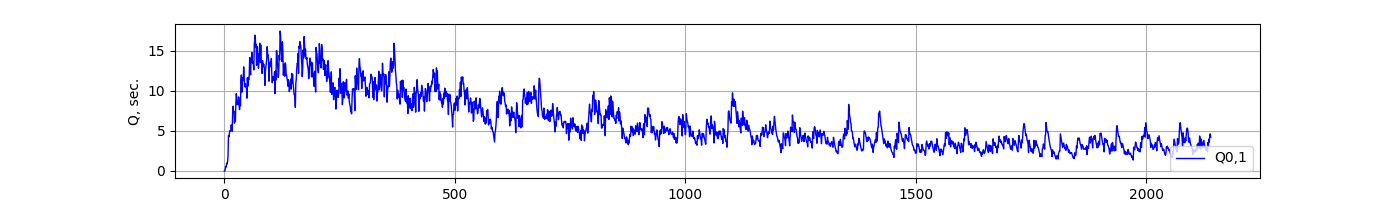

In [12]:
%matplotlib widget
MARLINController = []
s1 = CreateSim(False, "MARLIN", MARLINController)
dur = 24 * 3600
s1.t = 0
s1.run(dur)
s = s1

N = len(MARLINController)
fig = plt.figure(figsize=(14,2*N))
fig. tight_layout ()
for i in range(N):
    color = cm.brg(np.linspace(0, 1, len(MARLINController[i].TL)))

    ax = fig.add_subplot(N,1,i+1)
    
    ax.grid(True)
    ax.set_xlabel("steps")
    ax.set_ylabel("Q, sec.")
    for tli in range(len(MARLINController[i].TL)):
        if not(len(MARLINController[i].NB[tli])):
            data = MARLINController[i].data[tli]
            M = len(data)
            max = np.max(data)
            ax.plot(np.linspace(0,M,M),data, color = color[tli],linewidth = 1,label = f"Q{tli+i}")
            ax.axhline(max,color = "red")

        for tlij in range(len(MARLINController[i].NB[tli])-tli):
            data = MARLINController[i].data[tli][tlij]
            M = len(data)
            max = np.max(data)
            ax.plot(np.linspace(0,M,M),data, color = color[tli],linewidth = 1,label = "Q{0},{1}".format(tli+i, MARLINController[i].NB[tli][tlij]+i))
            #ax.axhline(max,color = "red")
    plt.legend(loc = 4)

